# Brainwave Service Upload
This Notebook is intended to simplify the training / upload process by splitting the two steps into two separate notebooks. In particular, this Notebook is for uploading a previously-trained model to the cloud, and doesn't contain any training code. It does have some sanity check code to ensure you're loading in the right model, before actually uploading it.

Even though these first few cells are repeated in the training Notebooks, it is necessary here since we still must set up the environment to load the model into memory.

In [36]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
%load_ext autoreload
%autoreload 2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14046399609483262152
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12419409782087342672
physical_device_desc: "device: XLA_CPU device"
]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Directories for models
custom_weights_dir_q = "/mnt/disks/acceldata/fromjavier/weights-quantized-224x224-fixval-best-final"
saved_model_dir = "/home/thomas/accel1/models"

## Prepare Data
Load the files we are going to use for training and testing. The public Top dataset consists of image formatted data, but our data has been preprocessed into a raw form. You will need to edit the paths as necessary.

In [38]:
from utils import normalize_and_rgb, image_with_label, count_events

In [39]:
import glob
# for 224x224:
datadir="/mnt/disks/acceldata/fromjavier/converted/rotation_224_v1"
# datadir="/mnt/disks/acceldata/copyfromnhan/MachineLearningNotebooks/data/test"

data_size = 224 #image width/height
test_files = glob.glob(os.path.join(datadir, 'test_file_*'))
n_test_events = count_events(test_files)
print("n_test_events =", n_test_events)

n_test_events = 404000


Getting data from /mnt/disks/acceldata/fromjavier/converted/rotation_224_v1/test_file_40.h5, indices [18, 19, 20, 21]
Converting data to img-like arrays
raw data shape:       (4, 224, 224)
sums shape:           (4, 1, 1)
images shape:         (4, 224, 224)
stacked images shape: (4, 224, 224, 3)
Making plots
Index 18: top


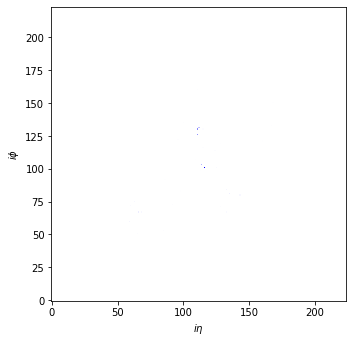

Index 19: top


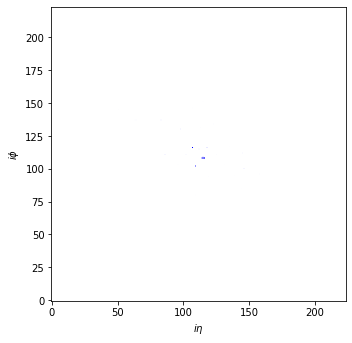

Index 20: qcd


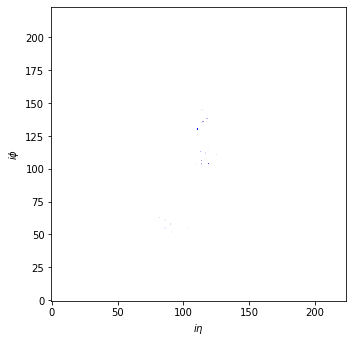

Index 21: qcd


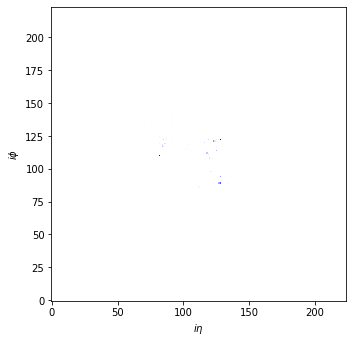

In [40]:
import os
import tables
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class TestHeatmap(object):
        
    def get_data_at_indices(self, train_file, indices):
        print('Getting data from {0}, indices {1}'.format(train_file, indices))
        f = tables.open_file(train_file, 'r')
        # data   = np.array(f.root.img_pt)[indices].copy() # Images # Costs a lot of memory
        # labels = np.array(f.root.label)[indices].copy() # Labels
        data = np.array([ f.root.img_pt[i].copy() for i in indices ])
        labels = np.array([ f.root.label[i].copy() for i in indices ])
        f.close()
        return data, labels

    def data_to_images(self, data, traditional=True):
        print('Converting data to img-like arrays')
        # Compute sum per data entry, for normalization purposes
        # data_sums = 1./np.sum(np.sum(data,axis=1),axis=-1)
        data_sums = 1./np.array([ data[i].max() for i in range(data.shape[0]) ])

        # Turn into len(indices) times 1x1 matrices
        data_sums_reshaped = data_sums.reshape([ -1, 1, 1 ])

        if traditional:
            # Normalize and scale to 255
            images = data * data_sums_reshaped * 255
            # Turn last axis (the plain number) into a 3x1 array (rgb)
            stacked_images = np.stack([images, images, images], axis=-1)

        else:
            # Go for a blue kind of plot
            # Normalize, invert, and scale to 255
            images = (data * data_sums_reshaped * -255).astype(int) + 255

            # Turn last axis (the plain number) into a 3x1 array (rgb)
            # The color that is kept 'white' is the one that shows up
            white = np.ones(images.shape, int) * 255
            stacked_images = np.stack([images, images, white], axis=-1)

        print('raw data shape:      ', data.shape)
        print('sums shape:          ', data_sums_reshaped.shape)
        print('images shape:        ', images.shape)
        print('stacked images shape:', stacked_images.shape)
        return stacked_images

    def plot_imgs(self, train_file, indices):
        data, labels = self.get_data_at_indices(train_file, indices)
        images = self.data_to_images(data, traditional=False)
        width = 5
        height = 5
        fontsize = 10

        print('Making plots')
        n_images = images.shape[0]
        for i in range(n_images):
            is_top = labels[i][0] == 0
            label_text = 'top' if is_top else 'qcd'
            print('Index {0}: {1}'.format(indices[i], label_text))

            image = images[i]

            plt.style.use('sonic.mplstyle')
            plt.figure(figsize=(width,height))
            ax = plt.subplot()
            for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(fontsize)

            plt.imshow(
                image,
                origin='lower', interpolation='nearest',label='top'
                )
            plt.xlabel(r'$i\eta$', fontsize=fontsize)
            plt.ylabel(r'$i\phi$', fontsize=fontsize)
            plt.tight_layout()
            plt.show()

plotter = TestHeatmap()

%matplotlib inline
plotter.plot_imgs(os.path.join(datadir, 'test_file_40.h5'), [18, 19, 20, 21])

## Load The Model

In [41]:
from utils import construct_model
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading quantized model")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(
        quantized=True, 
        saved_model_dir=saved_model_dir, 
        starting_weights_directory=custom_weights_dir_q, 
        is_training=False, 
        size=data_size
        )

Loading quantized model


KeyboardInterrupt: 

In [ ]:
print(in_images)
print(image_tensors)

## Service Definition

In [ ]:
model_name = "klijnsma_tquarkRN50_v1"
model_save_path = os.path.join(saved_model_dir, model_name)

while os.path.isdir(model_save_path):
    i = 0
    model_save_path = os.path.join(saved_model_dir, model_name + '_s' + str(i))
print('Saving to ' + model_save_path)
    
with sess.as_default():
    tf.saved_model.simple_save(
        sess, model_save_path,
        inputs={'images': image_tensors},
        # inputs={'images': image_tensors_1dim},
        outputs={'output_alias': preds}
        )


In [ ]:
input_tensors = image_tensors.name
output_tensors = preds.name

print(input_tensors)
print(output_tensors)

print(image_tensors_1dim.name)

## Deploy

Go to our GitHub repo "docs" folder to learn how to create a Model Management Account and find the required information below.

In [ ]:
import os

subscription_id = os.environ.get("SUBSCRIPTION_ID", "80defacd-509e-410c-9812-6e52ed6a0016")
resource_group = os.environ.get("RESOURCE_GROUP", "CMS_FPGA_Resources")
workspace_name = os.environ.get("WORKSPACE_NAME", "Fermilab")

# subscription_id = os.environ.get("SUBSCRIPTION_ID", "7ab7d5bc-5d9e-47ef-80e6-2dffa8ca83a1")
# resource_group = os.environ.get("RESOURCE_GROUP", "tw-accel-fpga-rg")
# workspace_name = os.environ.get("WORKSPACE_NAME", "tw-aml-ws-accel-fpga")

from azureml.core import Workspace

ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
ws.write_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

The first time the code below runs it will create a new service running your model. If you want to change the model you can make changes above in this notebook and save a new service definition. Then this code will update the running service in place to run the new model.

In [ ]:
from azureml.core.model import Model

model_name = "klijnsma_tquarkRN50_v1_s0"

from datetime import datetime
ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
description = '[{0}] testing fermilab-v2'.format(ts)

registered_model = Model.register(
    ws,
    model_save_path, model_name,
    description = description
    )
print("Successfully registered: ", registered_model.name, registered_model.description, registered_model.version, sep = '\t')


In [ ]:
from azureml.accel import AccelOnnxConverter

convert_request = AccelOnnxConverter.convert_tf_model(ws, registered_model, input_tensors, output_tensors)
convert_request.wait_for_completion(show_output=True)

In [ ]:
# If the above call succeeded, get the converted model
converted_model = convert_request.result
print(converted_model.name, converted_model.url, converted_model.version, converted_model.id,converted_model.created_time)

In [ ]:
from azureml.core.image import Image
from azureml.accel import AccelContainerImage

image_config = AccelContainerImage.image_configuration()
image_name = 'im-' + model_name.replace('_','-').lower()

image = Image.create(
    name = image_name,
    models = [converted_model],
    image_config = image_config, 
    workspace = ws
    )
image.wait_for_creation(show_output = True)

In [ ]:
print(image.image_location)

## Deploy to AKS

Taken from example azure notebook: https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/deployment/accelerated-models/accelerated-models-quickstart.ipynb

In [47]:
# (Re)import workspace if not already done above
import os
from azureml.core import Workspace

subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
workspace_name = "Fermilab"

ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
ws.write_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

Fermilab
CMS_FPGA_Resources
eastus2
80defacd-509e-410c-9812-6e52ed6a0016


In [48]:
from azureml.core.image import Image
from azureml.accel import AccelContainerImage

In [49]:
# image = Image(ws, name="im-klijnsma-tquarkrn50-v1")
# image = Image(ws, name="im-klijnsma-tquarkrn50-v2")
image = Image(ws, name="im-klijnsma-tquarkrn50-v1-s0")
print(image)

AccelContainerImage(workspace=Workspace.create(name='Fermilab', subscription_id='80defacd-509e-410c-9812-6e52ed6a0016', resource_group='CMS_FPGA_Resources'), name=im-klijnsma-tquarkrn50-v1-s0, id=im-klijnsma-tquarkrn50-v1-s0:1, tags={}, properties={}, version=1)


In [ ]:
from azureml.core.compute import AksCompute, ComputeTarget

# Uses the specific FPGA enabled VM (sku: Standard_PB6s)
# Standard_PB6s are available in:
# eastus, westus2, westeurope, southeastasia
prov_config = AksCompute.provisioning_configuration(
    vm_size = "Standard_PB6s",
    agent_count = 1, 
    location = "eastus"
    )

aks_name = 'aks-tkl-pb6-1'
# Create the cluster

aks_target = ComputeTarget.create(
    workspace = ws, 
    name = aks_name, 
    provisioning_configuration = prov_config
    )

In [50]:
# Get created ComputeTarget from portal
# Only use if not creating
from azureml.core.compute import AksCompute, ComputeTarget
aks_name = 'aks-tkl-pb6-1'
aks_target = ComputeTarget(ws, aks_name)

In [51]:
print(aks_target)

AksCompute(workspace=Workspace.create(name='Fermilab', subscription_id='80defacd-509e-410c-9812-6e52ed6a0016', resource_group='CMS_FPGA_Resources'), name=aks-tkl-pb6-1, id=/subscriptions/80defacd-509e-410c-9812-6e52ed6a0016/resourceGroups/CMS_FPGA_Resources/providers/Microsoft.MachineLearningServices/workspaces/Fermilab/computes/aks-tkl-pb6-1, type=AKS, provisioning_state=Succeeded, location=eastus2, tags=None)


Notes from the Azure tutorial:
Provisioning an AKS cluster might take awhile (15 or so minutes), and we want to wait until it's successfully provisioned before we can deploy a service to it. If you interrupt this cell, provisioning of the cluster will continue. You can also check the status in your Workspace under Compute.

In [ ]:
# aks_target.wait_for_completion(show_output = True)
# print(aks_target.provisioning_state)
# print(aks_target.provisioning_errors)

Deploy configuration and image to `AksComputeTarget`

In [52]:
from azureml.core.webservice import Webservice, AksWebservice

# Set the web service configuration (for creating a test service, we don't want autoscale enabled)
# Authentication is enabled by default, but for testing we specify False
aks_config = AksWebservice.deploy_configuration(
    autoscale_enabled = False,
    num_replicas=1,
    auth_enabled = False,
    )

# Will raise if not correctly configured
aks_config.validate_configuration()

# Check that the image that is being deployed to the webservice is valid.
# Will raise a WebserviceException if validation fails.
aks_config.validate_image(image)

print(aks_config)

Actually deploy the image:

In [53]:
aks_service_name ='aks-service-klijnsma-1'

aks_service = Webservice.deploy_from_image(
    workspace         = ws,
    name              = aks_service_name,
    image             = image,
    deployment_config = aks_config,
    deployment_target = aks_target
    )

Creating service


In [55]:
# Reload service from the portal:
aks_service = Webservice(ws, 'aks-service-klijnsma-1')
print(aks_service)
print(aks_service.state)

AksWebservice(workspace=Workspace.create(name='Fermilab', subscription_id='80defacd-509e-410c-9812-6e52ed6a0016', resource_group='CMS_FPGA_Resources'), name=aks-service-klijnsma-1, image_id=im-klijnsma-tquarkrn50-v1-s0:1, compute_type=AKS, state=Healthy, scoring_uri=http://168.62.41.193/, tags={}, properties={'azureml.git.repository_uri': 'https://github.com/Azure/MachineLearningNotebooks.git', 'mlflow.source.git.repoURL': 'https://github.com/Azure/MachineLearningNotebooks.git', 'azureml.git.branch': 'klijnsma-dev1', 'mlflow.source.git.branch': 'klijnsma-dev1', 'azureml.git.commit': '64bcd2312defb6cb0991f3f3898bee2480268ce3', 'mlflow.source.git.commit': '64bcd2312defb6cb0991f3f3898bee2480268ce3', 'azureml.git.dirty': 'True'})
Healthy


In [ ]:
# aks_service.wait_for_deployment(show_output = True)

# Client
There is a simple test client at amlrealtimeai.PredictionClient which can be used for testing. We'll use this client to score an image with our new service.

In [42]:
print(address)
print(port)
print(ssl_enabled)

52.179.86.149
80
False


In [56]:
# # from azureml.accel.client import PredictionClient
# from azureml.accel._client import PredictionClient
# # client = PredictionClient('sukha-fpga2.eastus.cloudapp.azure.com', 50051)
# client = PredictionClient('fermilab9441410115.azurecr.io/top-quark-resnet50-image', 2)
# print(client)


# Do the AKS thing instead:

# Using the grpc client in AzureML Accelerated Models SDK
from azureml.accel._client import PredictionClient

address = aks_service.scoring_uri
ssl_enabled = address.startswith("https")
address = address[address.find('/')+2:].strip('/')
port = 443 if ssl_enabled else 80

# Initialize AzureML Accelerated Models client
client = PredictionClient(
    address=address,
    port=port,
    use_ssl=ssl_enabled,
    service_name=aks_service.name
    )

In [57]:
print('address     = {0}'.format(address))
print('ssl_enabled = {0}'.format(ssl_enabled))
print('address     = {0}'.format(address))
print('port        = {0}'.format(port))
print('Client:')
print(client)

address     = 168.62.41.193
ssl_enabled = False
address     = 168.62.41.193
port        = 80
Client:


## Request
Let's see how our service does on a few images. It may get a few wrong.

In [58]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from tqdm import tqdm, tqdm_notebook
from utils import chunks
    
chunk_size = 1  # Brainwave only processes one request at a time


less_test_files = test_files[:1]


n_test_events = count_events(less_test_files)
chunk_num = int(n_test_events/chunk_size)+1

y_true = np.zeros((n_test_events,2))
y_pred = np.zeros((n_test_events,2))


i = 0
for img_chunk, label_chunk, real_chunk_size in tqdm_notebook(chunks(less_test_files, chunk_size, max_q_size=1, shuffle=False), total=chunk_num):
    np_array = np.float32(img_chunk)
    
    results = client.score_numpy_arrays(
        input_map = {
            # 'brainwave_resnet50_1_Version_0.1_input_1:0' : np_array
            # image_tensors.name : np_array,
            'Placeholder:0' : np_array
            }
        )
        
    y_pred[i,:] = results
    y_true[i,:] = label_chunk
    # print(results)
    # print(label_chunk)
    i+=1
    # if i>=1: break

KeyboardInterrupt: 

In [54]:
# Call the save results utility.
from utils import save_results

accuracy = accuracy_score(y_true[:,0], y_pred[:,0]>0.5)
auc = roc_auc_score(y_true, y_pred)

print("Accuracy:", accuracy, "AUC:", auc)

Accuracy: 0.935 AUC: 0.9833297331029186


## Cleanup
Run the cell below to delete your service.

In [ ]:
service.delete()